<a href="https://colab.research.google.com/github/SanjayanAri/single_cell_RNA_seq_works/blob/main/Seurat_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Seurat workflow

Author: Sanjayan.A

Runtime: V5e1 TPU

Following youtube tutorials to learn Single cell RNA sequencing analysis.
why TPU, the default runtime cpu lacks enough RAM to run the process hence a bigger system is needed. So i went with a TPU

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
install.packages("Seurat")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘dotCall64’, ‘gtools’, ‘caTools’, ‘plyr’, ‘tensor’, ‘BH’, ‘sitmo’, ‘sp’, ‘spam’, ‘globals’, ‘listenv’, ‘parallelly’, ‘zoo’, ‘lazyeval’, ‘crosstalk’, ‘RcppTOML’, ‘here’, ‘gplots’, ‘reshape2’, ‘gridExtra’, ‘RcppArmadillo’, ‘spatstat.data’, ‘spatstat.univar’, ‘spatstat.random’, ‘spatstat.utils’, ‘spatstat.sparse’, ‘goftest’, ‘abind’, ‘deldir’, ‘polyclip’, ‘FNN’, ‘dqrng’, ‘SeuratObject’, ‘cowplot’, ‘fastDummies’, ‘fitdistrplus’, ‘future’, ‘future.apply’, ‘ggrepel’, ‘ggridges’, ‘ica’, ‘igraph’, ‘irlba’, ‘leidenbase’, ‘lmtest’, ‘matrixStats’, ‘patchwork’, ‘pbapply’, ‘plotly’, ‘png’, ‘progressr’, ‘RANN’, ‘RcppAnnoy’, ‘RcppHNSW’, ‘reticulate’, ‘ROCR’, ‘RSpectra’, ‘Rtsne’, ‘scattermore’, ‘sctransform’, ‘spatstat.explore’, ‘spatstat.geom’, ‘uwot’, ‘RcppEigen’, ‘RcppProgress’




In [ ]:
library(Seurat)

In [ ]:
install.packages("hdf5r")

In [ ]:
getwd()

In [ ]:
#Loading the dataset and making a matrix
library(hdf5r)
nsclc.sparse.m <- Read10X_h5('20k_NSCLC_DTC_3p_nextgem_Multiplex_count_raw_feature_bc_matrix.h5')
str(nsclc.sparse.m)
cts <-  nsclc.sparse.m$`Gene Expression`


making the seurat object

In [ ]:
nsclc.seurat.obj <- CreateSeuratObject(counts = cts, project = "NSCLC", min.cells = 3, min.features = 200)
str(nsclc.seurat.obj)
nsclc.seurat.obj

An object of class Seurat
29552 features across 42081 samples within 1 assay
Active assay: RNA (29552 features, 0 variable features)
 1 layer present: counts

Quality control step

In [ ]:
View(nsclc.seurat.obj@meta.data)

% of mitochondrial genes, in lower quality we can see higher mitochondrial genes.
High mitochondrial content often means poor-quality or stressed or dying cells, so we have to filter this out.

In [ ]:
nsclc.seurat.obj[["percent.mt"]] <- PercentageFeatureSet(nsclc.seurat.obj, pattern = "^MT-")
View(nsclc.seurat.obj@meta.data)

visualizing these features through vln plot and a scatter plot

In [ ]:
VlnPlot(nsclc.seurat.obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
FeatureScatter(nsclc.seurat.obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") +
  geom_smooth(method = 'lm')

nFeature_RNA = number of genes detected per cell

nCount_RNA = total transcripts/UMIs per cell

percent.mt = % mitochondrial reads

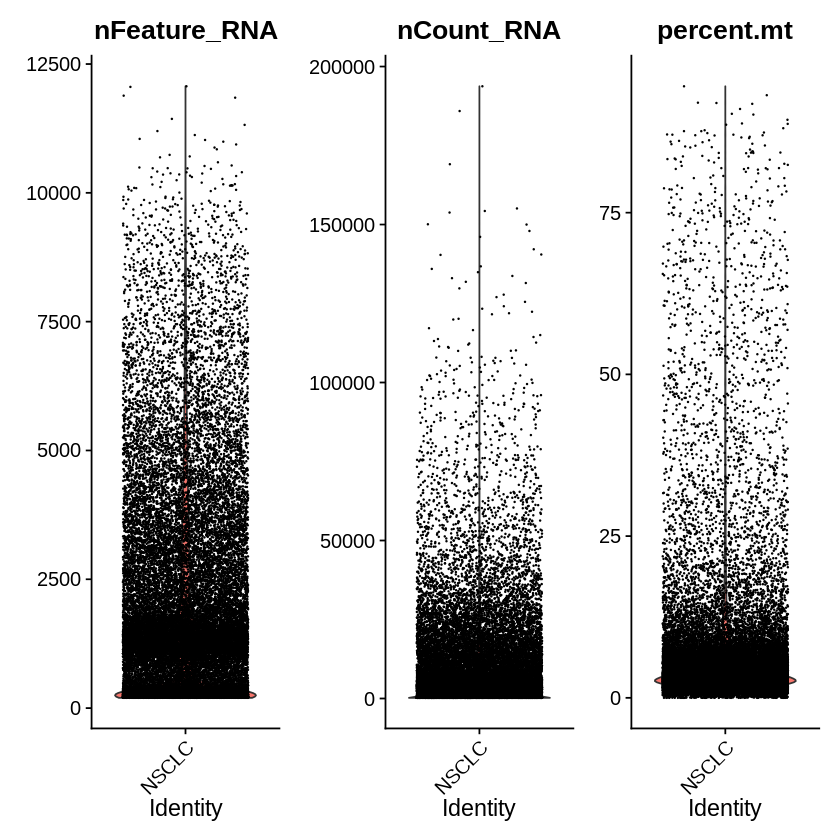


This violin plot shows the quality of the the object,

The polt on left nFeature_RNA is the number of detected genes per cell the range goes from ~0 to 12,500 genes. we can see most cells cluster between ~500–5,000 genes. A few cells show very high values (>7,500 genes) these could be doublets (two or more cells captured together).
Very low values (<200–300 genes) usually represent empty droplets or poor-quality cells.

on the right we see Mitochondrial gene fraction. Most cells are under 10–15%, which is expected for healthy cells,
but there are some extending up to >75% mitochondrial reads.
The cells with high %MT (>20%) are typically stressed, dying, or low-quality and are usually filtered out.

In the middle is the nCount_RNA which ic Total transcripts/UMIs per cell, majority cells lie below 50,000 counts, the outliers which has more than 100,000 are most likely to be doublets.

In [ ]:
# Filtering
nsclc.seurat.obj <- subset(nsclc.seurat.obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 &
                          percent.mt < 5)

my filtering criteria here is removing the cells which has less than 200 genes detected, and also removing the cells which has more than 2500 genes detected. I am also removing if the mitochondria content is more than 5% of the mapped reads.

In [ ]:
# Normalising the data (default function)
nsclc.seurat.obj <- NormalizeData(nsclc.seurat.obj)
str(nsclc.seurat.obj)

Normalization is done with the default method of log normalization and multiplied with scaling factor.  

In [ ]:
nsclc.seurat.obj <- FindVariableFeatures(nsclc.seurat.obj, selection.method = "vst", nfeatures = 2000)

In [ ]:
# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(nsclc.seurat.obj), 10)

print(top10)

In [ ]:
plot1 <- VariableFeaturePlot(nsclc.seurat.obj)

plot1 <- LabelPoints(
  plot = plot1,
  points = top10,
  repel = TRUE,
  size = 5,
  box = TRUE
)


plot1 +
  theme_classic(base_size = 14) +
  theme(
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14, face = "bold"),
    legend.position = "top"
  ) +
  labs(
    title = "Highly Variable Genes",
    x = "Average Expression (log10)",
    y = "Standardized Variance"
  )

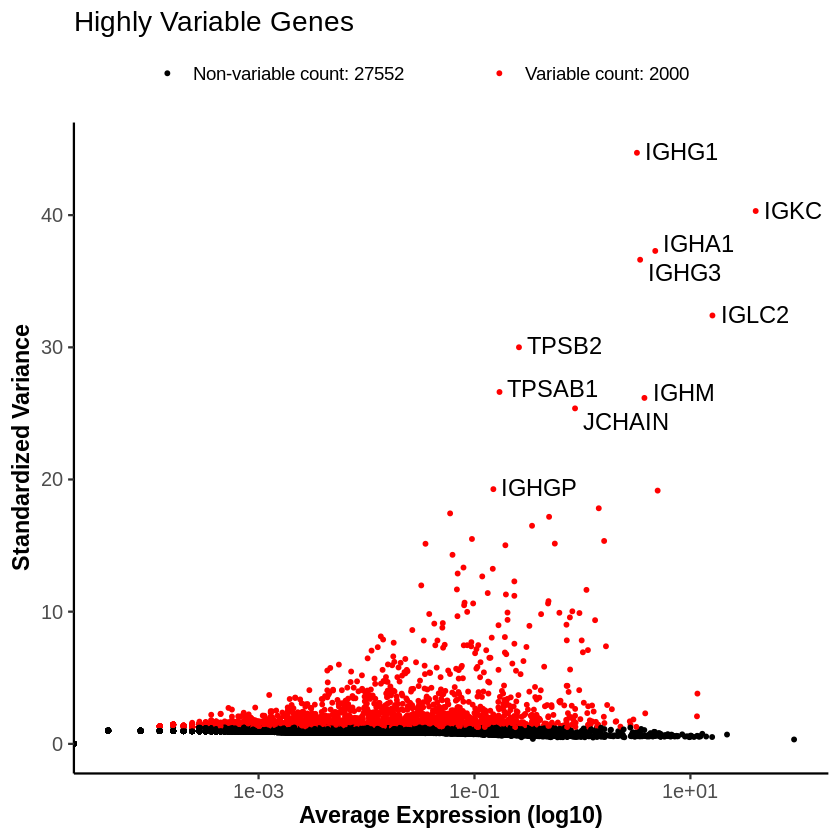

This is a high variable gene plot, a step before principle component analysis for dimentional reduction. x axis is log10 value of average expression showing the Mean expression level of each gene across all cells. Left side indicating rarely expressed genes, Right side showing highly expressed genes.

Y axis is log10 value of standardize variance showing how much a gene’s expression varies across cells, normalized by its mean. The
higher values indicates more variable across cells.

## Scaling
Here we are getting all the genes in the and storing them in all.gene dataset, scaling every gene.
Centers each gene’s expression across cells and subtracts the mean expression of that gene. Scales (standardizes) expression and divides by the standard deviation (so variance = 1). After this, each gene will have mean = 0 and variance = 1 across cells.

Scaling ensures that all genes contribute fairly to dimensionality reduction.

In [ ]:
# Scaling
all.genes <- rownames(nsclc.seurat.obj)
nsclc.seurat.obj <- ScaleData(nsclc.seurat.obj, features = all.genes)

In [ ]:
str(nsclc.seurat.obj)

## Dimensity reduction
picks the top highly variable genes and avoids the noise, and performs PCA (principle component analysis) on the scaled data to identify the variance, which can be viewed through dim plot and elbow plot

In [ ]:
# Perform Linear dimensionality reduction
nsclc.seurat.obj <- RunPCA(nsclc.seurat.obj, features = VariableFeatures(object = nsclc.seurat.obj))

In [ ]:
# visualize PCA results
print(nsclc.seurat.obj[["pca"]], dims = 1:5, nfeatures = 5)
DimHeatmap(nsclc.seurat.obj, dims = 1:15, cells = 1000, balanced = TRUE)

In [ ]:
# determine dimensionality of the data
ElbowPlot(nsclc.seurat.obj)


In this elbow plot, X axis is the principle component and the y axis is the std deviation, showing variance, as we see the first 5 captured are having higher degree of variance showing biological variance. and above 15 are showing least variation.

so for further analysis I will choose only first 10-15.

## Clustering

In [ ]:
#clustering
nsclc.seurat.obj <- FindNeighbors(nsclc.seurat.obj, dims = 1:15)

This builds a K-nearest neighbor (KNN) graph of your cells, using the principle components we have taken. we use PC's to reduce the noise and focus on biological variance.

In [ ]:
# understanding resolution
nsclc.seurat.obj <- FindClusters(nsclc.seurat.obj, resolution = c(0.1,0.3, 0.5, 0.7, 1))
View(nsclc.seurat.obj@meta.data)

We will look at the clusters in multiple resolution, 0.1 being lower and the 1.0 being higher resolution. higher resolution better difference.

In [ ]:
# Visualisation
DimPlot(nsclc.seurat.obj, group.by = "RNA_snn_res.0.5", label = TRUE)

In [ ]:
# setting identity of clusters
Idents(nsclc.seurat.obj)
Idents(nsclc.seurat.obj) <- "RNA_snn_res.0.1"
Idents(nsclc.seurat.obj)